In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
tfd = tfp.distributions
tfpl = tfp.layers

We utilize the densevariational layers, released in tensorflow probability late last year. The dense variational layer carry out variational inference to ascertain the posterior distributions over the weights and biases of the layer object.

The broad inputs to the this layer are:
1. A prior distribution over the parameters of the layer,
2. A trainable posterior distribution over the parameters of the layer,
3. A loss function to minimize (added during the compile): the layer will also add its own KL divergence loss just like how extra losses are added when you add weight regularization in normal keras,
4. The scaling for the Kullback Leibler Divergence for the layer: This is required as the "loss" is calculated over the batch of data passed but the KL divergence is calcuated for the entire distribution (or the entire sample), So we need to re-scale the KL divergence loss of each layer by 1/Sample_Size
5. a flag to determine if the KL divergence is to be calculated using exact formulae, using a used defined subroutine or via sampling. I'm not using this flag, so it will be estimated via sampling.

Below, we have the prior distribution for the layer (bullet 1 in the list above). As can be seen, irrespective of the input, this function will just calculate the total number of paramters for the layer (n=kernel_size+bias_size) and define an independent, multivariate standard normal over this n-dimensional space. 

In [5]:
def prior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n,dtype=dtype),scale=1.0),reinterpreted_batch_ndims=1)

Below, we have the trainable posterior function (2 in the list above). As you can see, I am using a variablelayer, which passes tensorflow variables as the parameters of the next layer. As tf.Variable's, they are all trainable parameters. The last layer in this meta-layer is an Independent, multivariate normal over this n-dimensional space, where now the means and covariances are trainable tf.Variable's. They shall be trained using the losses to be defined.

In [6]:
def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

Below, we have the classical Negative Log Likelihood loss, where the log likelihood of the true data is evaluated with respect to the distribution of the output layer of the model. Please note that each layer will be adding its own KL divergence to this loss.

In [9]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Below, we have sample data with a high degree of variance. Clearly the data has aleatoric uncertainty, the epistemic uncertainty will be introduced later.

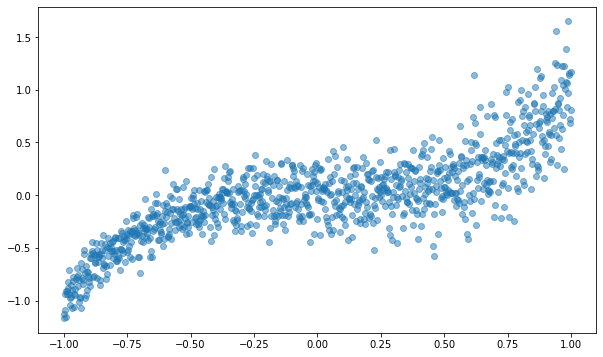

In [47]:
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.figure(figsize=(10,6))
plt.scatter(x_train, y_train, marker='o', alpha=0.5, label='Data')

Below, we outline the BNN model. It has 2 layers: the input layer with 8 nodes and the second layer with 2-output nodes that define the mean function and the standard deviation function over the output predictions.

In [27]:
N=x_train.shape[0]
model=Sequential([
    tfpl.DenseVariational(8, input_shape=(1,),make_posterior_fn=posterior,make_prior_fn=prior,kl_weight=1/N,activation='sigmoid'),
    tfpl.DenseVariational(tfpl.IndependentNormal.params_size(1),make_posterior_fn=posterior,make_prior_fn=prior,kl_weight=1/N),
    tfpl.IndependentNormal(1)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_7 (DenseVa (None, 8)                 32        
_________________________________________________________________
dense_variational_8 (DenseVa (None, 2)                 36        
_________________________________________________________________
independent_normal_5 (Indepe multiple                  0         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))

In [29]:
model.fit(x_train, y_train, epochs=1000)
model.evaluate(x_train, y_train)

Epoch 1/1000
32/32 [==============================] - 1s 847us/step - loss: 4.6809
Epoch 2/1000
32/32 [==============================] - 0s 828us/step - loss: 12.9565
Epoch 3/1000
32/32 [==============================] - 0s 835us/step - loss: 2.2613
Epoch 4/1000
32/32 [==============================] - 0s 818us/step - loss: 2.3262
Epoch 5/1000
32/32 [==============================] - 0s 801us/step - loss: 2.1710
Epoch 6/1000
32/32 [==============================] - 0s 843us/step - loss: 1.6923
Epoch 7/1000
32/32 [==============================] - 0s 855us/step - loss: 2.4753
Epoch 8/1000
32/32 [==============================] - 0s 825us/step - loss: 1.4485
Epoch 9/1000
32/32 [==============================] - 0s 832us/step - loss: 1.6492
Epoch 10/1000
32/32 [==============================] - 0s 838us/step - loss: 1.5972
Epoch 11/1000
32/32 [==============================] - 0s 841us/step - loss: 2.0159
Epoch 12/1000
32/32 [==============================] - 0s 827us/step - loss: 1.8798


32/32 [==============================] - 0s 757us/step - loss: 0.1104
Epoch 99/1000
32/32 [==============================] - 0s 752us/step - loss: 0.1380
Epoch 100/1000
32/32 [==============================] - 0s 785us/step - loss: 0.1333
Epoch 101/1000
32/32 [==============================] - 0s 735us/step - loss: 0.1318
Epoch 102/1000
32/32 [==============================] - 0s 728us/step - loss: 0.1625
Epoch 103/1000
32/32 [==============================] - 0s 744us/step - loss: 0.2146
Epoch 104/1000
32/32 [==============================] - 0s 762us/step - loss: 0.1590
Epoch 105/1000
32/32 [==============================] - 0s 807us/step - loss: 0.1334
Epoch 106/1000
32/32 [==============================] - 0s 730us/step - loss: 0.1377
Epoch 107/1000
32/32 [==============================] - 0s 761us/step - loss: 0.1490
Epoch 108/1000
32/32 [==============================] - 0s 725us/step - loss: 0.1251
Epoch 109/1000
32/32 [==============================] - 0s 791us/step - loss: 0.1

32/32 [==============================] - 0s 721us/step - loss: 0.0419
Epoch 195/1000
32/32 [==============================] - 0s 750us/step - loss: 0.0434
Epoch 196/1000
32/32 [==============================] - 0s 723us/step - loss: 0.0597
Epoch 197/1000
32/32 [==============================] - 0s 715us/step - loss: 0.0326
Epoch 198/1000
32/32 [==============================] - 0s 742us/step - loss: 0.0564
Epoch 199/1000
32/32 [==============================] - 0s 739us/step - loss: -0.0117
Epoch 200/1000
32/32 [==============================] - 0s 713us/step - loss: -4.9815e-04
Epoch 201/1000
32/32 [==============================] - 0s 786us/step - loss: 0.0230
Epoch 202/1000
32/32 [==============================] - 0s 720us/step - loss: 0.0533
Epoch 203/1000
32/32 [==============================] - 0s 792us/step - loss: -0.0280
Epoch 204/1000
32/32 [==============================] - 0s 764us/step - loss: 0.0248
Epoch 205/1000
32/32 [==============================] - 0s 767us/step - l

32/32 [==============================] - 0s 749us/step - loss: -0.1093
Epoch 290/1000
32/32 [==============================] - 0s 729us/step - loss: -0.1487
Epoch 291/1000
32/32 [==============================] - 0s 705us/step - loss: -0.1013
Epoch 292/1000
32/32 [==============================] - 0s 768us/step - loss: -0.0867
Epoch 293/1000
32/32 [==============================] - 0s 725us/step - loss: -0.0995
Epoch 294/1000
32/32 [==============================] - 0s 742us/step - loss: -0.0813
Epoch 295/1000
32/32 [==============================] - 0s 702us/step - loss: -0.0803
Epoch 296/1000
32/32 [==============================] - 0s 738us/step - loss: -0.1006
Epoch 297/1000
32/32 [==============================] - 0s 798us/step - loss: -0.1254
Epoch 298/1000
32/32 [==============================] - 0s 765us/step - loss: -0.0716
Epoch 299/1000
32/32 [==============================] - 0s 772us/step - loss: -0.1265
Epoch 300/1000
32/32 [==============================] - 0s 807us/step

32/32 [==============================] - 0s 753us/step - loss: -0.1150
Epoch 385/1000
32/32 [==============================] - 0s 723us/step - loss: -0.0825
Epoch 386/1000
32/32 [==============================] - 0s 769us/step - loss: -0.1338
Epoch 387/1000
32/32 [==============================] - 0s 785us/step - loss: -0.1200
Epoch 388/1000
32/32 [==============================] - 0s 746us/step - loss: -0.1121
Epoch 389/1000
32/32 [==============================] - 0s 784us/step - loss: -0.1361
Epoch 390/1000
32/32 [==============================] - 0s 755us/step - loss: -0.1185
Epoch 391/1000
32/32 [==============================] - 0s 762us/step - loss: -0.1047
Epoch 392/1000
32/32 [==============================] - 0s 749us/step - loss: -0.0903
Epoch 393/1000
32/32 [==============================] - 0s 736us/step - loss: -0.1160
Epoch 394/1000
32/32 [==============================] - 0s 745us/step - loss: -0.1483
Epoch 395/1000
32/32 [==============================] - 0s 772us/step

32/32 [==============================] - 0s 762us/step - loss: -0.1233
Epoch 480/1000
32/32 [==============================] - 0s 735us/step - loss: -0.1494
Epoch 481/1000
32/32 [==============================] - 0s 748us/step - loss: -0.1040
Epoch 482/1000
32/32 [==============================] - 0s 723us/step - loss: -0.1264
Epoch 483/1000
32/32 [==============================] - 0s 732us/step - loss: -0.1052
Epoch 484/1000
32/32 [==============================] - 0s 761us/step - loss: -0.1202
Epoch 485/1000
32/32 [==============================] - 0s 721us/step - loss: -0.1364
Epoch 486/1000
32/32 [==============================] - 0s 745us/step - loss: -0.1006
Epoch 487/1000
32/32 [==============================] - 0s 713us/step - loss: -0.1719
Epoch 488/1000
32/32 [==============================] - 0s 747us/step - loss: -0.1118
Epoch 489/1000
32/32 [==============================] - 0s 728us/step - loss: -0.1347
Epoch 490/1000
32/32 [==============================] - 0s 736us/step

32/32 [==============================] - 0s 725us/step - loss: -0.1167
Epoch 575/1000
32/32 [==============================] - 0s 733us/step - loss: -0.1230
Epoch 576/1000
32/32 [==============================] - 0s 698us/step - loss: -0.1239
Epoch 577/1000
32/32 [==============================] - 0s 705us/step - loss: -0.1708
Epoch 578/1000
32/32 [==============================] - 0s 742us/step - loss: -0.1081
Epoch 579/1000
32/32 [==============================] - 0s 689us/step - loss: -0.1210
Epoch 580/1000
32/32 [==============================] - 0s 718us/step - loss: -0.1000
Epoch 581/1000
32/32 [==============================] - 0s 710us/step - loss: -0.1033
Epoch 582/1000
32/32 [==============================] - 0s 713us/step - loss: -0.1039
Epoch 583/1000
32/32 [==============================] - 0s 700us/step - loss: -0.1035
Epoch 584/1000
32/32 [==============================] - 0s 685us/step - loss: -0.0887
Epoch 585/1000
32/32 [==============================] - 0s 702us/step

32/32 [==============================] - 0s 707us/step - loss: -0.1359
Epoch 670/1000
32/32 [==============================] - 0s 712us/step - loss: -0.1368
Epoch 671/1000
32/32 [==============================] - 0s 714us/step - loss: -0.0919
Epoch 672/1000
32/32 [==============================] - 0s 733us/step - loss: -0.1353
Epoch 673/1000
32/32 [==============================] - 0s 698us/step - loss: -0.0807
Epoch 674/1000
32/32 [==============================] - 0s 742us/step - loss: -0.1471
Epoch 675/1000
32/32 [==============================] - 0s 722us/step - loss: -0.1763
Epoch 676/1000
32/32 [==============================] - 0s 712us/step - loss: -0.1235
Epoch 677/1000
32/32 [==============================] - 0s 761us/step - loss: -0.1516
Epoch 678/1000
32/32 [==============================] - 0s 724us/step - loss: -0.1487
Epoch 679/1000
32/32 [==============================] - 0s 724us/step - loss: -0.1004
Epoch 680/1000
32/32 [==============================] - 0s 691us/step

32/32 [==============================] - 0s 715us/step - loss: -0.1150
Epoch 765/1000
32/32 [==============================] - 0s 705us/step - loss: -0.1214
Epoch 766/1000
32/32 [==============================] - 0s 692us/step - loss: -0.1069
Epoch 767/1000
32/32 [==============================] - 0s 801us/step - loss: -0.1013
Epoch 768/1000
32/32 [==============================] - 0s 729us/step - loss: -0.0846
Epoch 769/1000
32/32 [==============================] - 0s 681us/step - loss: -0.1427
Epoch 770/1000
32/32 [==============================] - 0s 698us/step - loss: -0.0996
Epoch 771/1000
32/32 [==============================] - 0s 704us/step - loss: -0.1475
Epoch 772/1000
32/32 [==============================] - 0s 716us/step - loss: -0.1457
Epoch 773/1000
32/32 [==============================] - 0s 712us/step - loss: -0.1361
Epoch 774/1000
32/32 [==============================] - 0s 718us/step - loss: -0.1177
Epoch 775/1000
32/32 [==============================] - 0s 705us/step

32/32 [==============================] - 0s 757us/step - loss: -0.1254
Epoch 860/1000
32/32 [==============================] - 0s 838us/step - loss: -0.1025
Epoch 861/1000
32/32 [==============================] - 0s 859us/step - loss: -0.1662
Epoch 862/1000
32/32 [==============================] - 0s 876us/step - loss: -0.1128
Epoch 863/1000
32/32 [==============================] - 0s 960us/step - loss: -0.0985
Epoch 864/1000
32/32 [==============================] - 0s 879us/step - loss: -0.1076
Epoch 865/1000
32/32 [==============================] - 0s 804us/step - loss: -0.1366
Epoch 866/1000
32/32 [==============================] - 0s 704us/step - loss: -0.0991
Epoch 867/1000
32/32 [==============================] - 0s 760us/step - loss: -0.1273
Epoch 868/1000
32/32 [==============================] - 0s 738us/step - loss: -0.1381
Epoch 869/1000
32/32 [==============================] - 0s 767us/step - loss: -0.1340
Epoch 870/1000
32/32 [==============================] - 0s 745us/step

32/32 [==============================] - 0s 737us/step - loss: -0.1653
Epoch 955/1000
32/32 [==============================] - 0s 727us/step - loss: -0.1157
Epoch 956/1000
32/32 [==============================] - 0s 756us/step - loss: -0.1360
Epoch 957/1000
32/32 [==============================] - 0s 720us/step - loss: -0.0988
Epoch 958/1000
32/32 [==============================] - 0s 738us/step - loss: -0.1331
Epoch 959/1000
32/32 [==============================] - 0s 721us/step - loss: -0.1262
Epoch 960/1000
32/32 [==============================] - 0s 688us/step - loss: -0.1187
Epoch 961/1000
32/32 [==============================] - 0s 730us/step - loss: -0.1332
Epoch 962/1000
32/32 [==============================] - 0s 706us/step - loss: -0.1107
Epoch 963/1000
32/32 [==============================] - 0s 753us/step - loss: -0.0784
Epoch 964/1000
32/32 [==============================] - 0s 760us/step - loss: -0.1337
Epoch 965/1000
32/32 [==============================] - 0s 685us/step

-0.13402873277664185

As each weight and bias in our model is a random variable, we need to take random samples for this space of distributions and use each sampled set to make a prediction for an input. On repeating this operation, we converge toward our estimates of the mean of the prediction and the variance of the prediction.

In [31]:
samples=x_train.shape[0]
sampling=30
y_preds_sample=np.zeros((samples,sampling))
y_upper_sample=np.zeros((samples,sampling))
y_lower_sample=np.zeros((samples,sampling))
for i in range(sampling):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    
    y_preds_sample[:,i]=y_hat[:,0]
    y_upper_sample[:,i]=y_hat_p2sd[:,0]
    y_lower_sample[:,i]=y_hat_m2sd[:,0]
    

Now, the we have the samples, we can evaluate the mean over the samples and the aleatoric and epistemic uncertainty in the predictions.

In [49]:
y_preds=np.mean(y_preds_sample,axis=1)
y_preds_var=np.std(y_preds_sample,axis=1)
y_preds_u=y_preds+2.0*y_preds_var
y_preds_l=y_preds-2.0*y_preds_var
y_upper=np.mean(y_upper_sample,axis=1)
y_lower=np.mean(y_lower_sample,axis=1)

In the plot below, the data is represented by circles.
The mean via the dark line.
The epistemic uncertainty 95% prediction interval is the dark grey zone, and the overall uncertainty (epistemic and aleatoric) 95% prediction interval is the light grey zone.

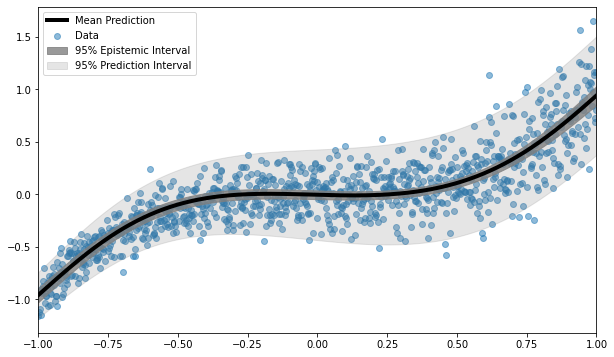

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(x_train, y_train, marker='o', alpha=0.5, label='Data')
plt.plot(x_train,y_preds,'k',linewidth=4,label='Mean Prediction')
plt.fill_between(x_train[:,0],y_preds_u,y_preds_l,color='gray',alpha=0.8,label='95% Epistemic Interval')
plt.fill_between(x_train[:,0],y_upper,y_lower,color='gray',alpha=0.2,label='95% Prediction Interval')
plt.xlim(-1,1)
plt.legend()